# Conversion of Image Zip to HDF5

Initialization Code

In [2]:
%matplotlib inline
import sys
from zipfile import ZipFile
from PIL import Image # if not present:  pip install pillow

import matplotlib.pyplot as plt
import numpy as np
import h5py

In [3]:
def downsample(myarr,factor,estimator=np.nanmean):
    """
    Downsample a 2D array by averaging over *factor* pixels in each axis.
    Crops upper edge if the shape is not a multiple of factor.

    This code is pure np and should be fast.

    keywords:
        estimator - default to mean.  You can downsample by summing or
            something else if you want a different estimator
            (e.g., downsampling error: you want to sum & divide by sqrt(n))
    """
    ys,xs = myarr.shape
    crarr = myarr[:ys-(ys % int(factor)),:xs-(xs % int(factor))]
    dsarr = estimator( np.concatenate([[crarr[i::factor,j::factor] 
        for i in range(factor)] 
        for j in range(factor)]), axis=0)
    return dsarr

## Loading the Images 

The patterns are assumed to be in a zip file, from which we extract them and save them into a HDF5 file.

In [4]:
# filename of the zip file, relative to current directory
zip_filename = './GaN_Polytypes/polytypeImages.zip'

zip_image_dir = '' # in this zip, the images were saved at the root level 
zip_image_ext = '.tiff'

zip_background_name = None # none if background is extra file outside of zip
background_filename='./GaN_Polytypes/StaticBackground.tiff'

In [ ]:
# test to see how importing works...
with ZipFile(zip_filename) as archive:
    for idx, entry in enumerate(archive.namelist()):
        if idx<5:
            if (zip_image_dir in entry) and (zip_image_ext in entry):
                # now we have an image filename in entry...
                img_name=entry.replace(zip_image_dir,'')
                img_name=img_name.replace(zip_image_ext,'')
                numbers=img_name.split('_')
                img_row=numbers[0]
                img_col=numbers[1]
               
                print('pattern name in zip:', entry)
                print('extracted row, column numbers in map: ', img_row, img_col)
                with archive.open(entry) as file:
                    img = Image.open(file) #.convert('LA')
                    print('pattern dims, mode, bytes:', img.size, img.mode, len(img.getdata()))
                    img_arr =np.array(img)
                    print(img_arr)
                    print()
                    plt.figure()
                    plt.imshow(img_arr)

Enter the map parameters from CTF etc, change manually for now:     

In [10]:
# map parameters     
img_width  = img.size[0] # last img that is loaded in above cell
img_height = img.size[1]        
map_width  = 196 # CTF: XCells 196
map_height = 172 # CTF: YCells 172
xstepmu=0.15 # CTF: XStep 0.1500
ystepmu=0.15 # CTF: YStep 0.1500
NImages=map_width*map_height

Test downsampling of the data to reduce file size if possible:

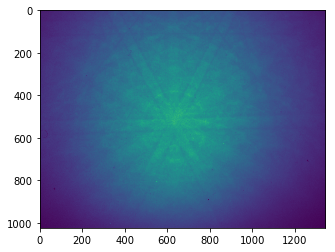

[[4336 4264 4128 ..., 4200 4064 4312]
 [4328 4296 4112 ..., 4120 4296 4320]
 [4280 4248 4296 ..., 4064 4224 4112]
 ..., 
 [2824 2976 3000 ..., 2584 2584 2512]
 [2880 2904 2928 ..., 2592 2544 2608]
 [2800 2840 2936 ..., 2584 2488 2528]]


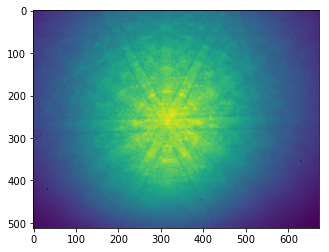

[[17224 16664 17240 ..., 16384 16600 16992]
 [17040 17008 17104 ..., 16576 16536 16688]
 [17152 16808 17064 ..., 16840 16760 16936]
 ..., 
 [11624 11632 11552 ..., 10336 10248 10184]
 [11680 11624 11704 ..., 10248 10240 10224]
 [11424 11600 11680 ..., 10120 10272 10168]]


In [6]:
# test downsampling
plt.figure()
plt.imshow(img_arr)
plt.show()
print(img_arr)

# bin by a factor of 2
binning=2

# sum the pixel intensities to retain INTEGER values in binned array (save memory in hdf5)
# we need to be sure not to exceed the 16bit integer range in the WHOLE MAP if using np.sum!
binning_estimator=np.sum
img_arr_binned=downsample(img_arr,2, estimator=binning_estimator)
plt.figure()
plt.imshow(img_arr_binned)
plt.title('binning: sum')
plt.show()
print(img_arr_binned)

# estimator=np.nanmean will result in float values (32bit) 
# to save memory, we can use rounding and conversion to 16bit integers
binning_estimator=np.nanmean
img_arr_binned=np.rint(downsample(img_arr,2, estimator=binning_estimator)).astype(np.uint16)
plt.figure()
plt.imshow(img_arr_binned)
plt.title('binning: mean and round to np.uint16')
plt.show()
print(img_arr_binned)

In [7]:
# if flatfielding background in zip
if not (zip_background_name is None):
    with ZipFile(zip_filename) as archive:
        with archive.open(zip_background_name) as file:
            img = Image.open(file) #.convert('LA')
            print(img.size, img.mode, len(img.getdata()))
            bg_img_arr =np.array(img)
            print(bg_img_arr)
            plt.figure()
            plt.imshow(bg_img_arr)

Loading background from file:  ./GaN_Polytypes/StaticBackground.tiff
(1344, 1024) I;16 1376256
[[1870 1873 1872 ..., 1887 1882 1898]
 [1861 1875 1876 ..., 1899 1902 1886]
 [1881 1880 1876 ..., 1906 1891 1895]
 ..., 
 [1654 1665 1671 ..., 1647 1654 1642]
 [1658 1673 1675 ..., 1650 1647 1651]
 [1652 1668 1676 ..., 1653 1660 1632]]


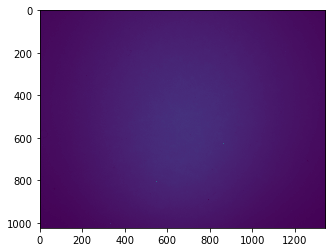

In [8]:
# flatfielding background extra file
print('Loading background from file: ', background_filename)
img = Image.open(background_filename) #.convert('LA')
print(img.size, img.mode, len(img.getdata()))
bg_img_arr =np.array(img)
print(bg_img_arr)
plt.figure()
plt.imshow(bg_img_arr)


In [9]:
# export to hdf5
binning=2
img_height = img_height // binning
img_width = img_width  // binning
binning_estimator=np.nanmean

iStart=0
iEnd=NImages

HDF5FileName='GaN_poly2.hdf5' 

DataGroup='Scan 0/EBSD/Data/'
HeaderGroup='Scan 0/EBSD/Header/'

# create new HDF5 File
f5=h5py.File(HDF5FileName,"w") # overwrite if exists
f5["Manufacturer"]="pattern_zip_to_hdf5"
f5["Version"]="0.1"



# h5ebsd HEADER INFO Data

# create empty datasets for h5ebsd format
# (empty datasets take no space)
f5.create_dataset(DataGroup+"BEAM X", (NImages,) ,dtype=np.int32,compression='gzip')
f5.create_dataset(DataGroup+"BEAM Y", (NImages,) ,dtype=np.int32,compression='gzip')
f5.create_dataset(DataGroup+"PCX" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"PCY" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"DD" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"phi1", (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"PHI" , (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"phi2", (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"X Position", (NImages,) ,dtype=np.float32,compression='gzip')
f5.create_dataset(DataGroup+"Y Position", (NImages,) ,dtype=np.float32,compression='gzip')

f5[HeaderGroup+"NCOLS"]=map_width
f5[HeaderGroup+"NROWS"]=map_height
f5[HeaderGroup+"PatternHeight"]=img_height
f5[HeaderGroup+"PatternWidth"]=img_width
f5[HeaderGroup+"X Resolution"]=xstepmu  # microns
f5[HeaderGroup+"Y Resolution"]=ystepmu  # microns

# staticBackround
#f5.create_dataset(DataGroup+"StaticBackground", (img_height,img_width), dtype=np.uint16)
f5[DataGroup+"StaticBackground"]=np.rint(downsample(bg_img_arr, binning, 
                                    estimator=binning_estimator)).astype(np.uint16)

# create empty data set for Patterns, recompress (max=9) using hdf5-gzip filter
dset_patterns=f5.create_dataset(DataGroup+'RawPatterns',
                                (NImages,img_height,img_width), 
                                dtype=np.uint16,
                                chunks=(1,img_height,img_width),
                                compression='gzip',compression_opts=9)

i=0
with ZipFile(zip_filename) as archive:
    for idx, entry in enumerate(archive.namelist()):
        if (zip_image_dir in entry) and (zip_image_ext in entry):
            #if i>100:
            #    break
            # now we have an image filename in entry...
            img_name=entry.replace(zip_image_dir,'')
            img_name=img_name.replace(zip_image_ext,'')
            numbers=img_name.split('_')
            img_row=int(numbers[0])
            img_col=int(numbers[1])
            with archive.open(entry) as file:
                img = Image.open(file)
                img_arr = np.rint(downsample(np.array(img), binning,
                            estimator=binning_estimator)).astype(np.uint16)
                dset_patterns[i]=img_arr
            # save scan indices = map position index of image i
            f5[DataGroup+"BEAM X"][i]=img_col    #i % MapWidth
            f5[DataGroup+"BEAM Y"][i]=img_row    #i // MapWidth
            
            # some dummy defaults for the projection center
            f5[DataGroup+"DD"][i]  = 1.0
            f5[DataGroup+"PCX"][i] = 0.5
            f5[DataGroup+"PCY"][i] = 0.5
            i+=1
        
        # live update progress info
        progress=100.0*(i+1)/NImages
        sys.stdout.write("\rtotal patterns: %5i current:%5i progress: %4.2f%%"
                         %(NImages,i,progress) )
        sys.stdout.flush()
        
f5.close()   

total patterns: 33712 current:33712 progress: 100.00%

## Example: Loading the Pattern Data from the HDF5

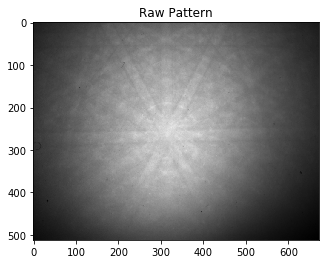

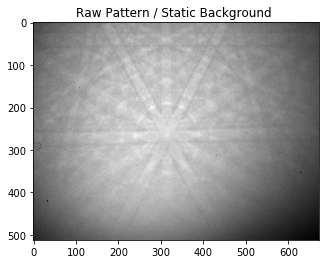

In [11]:
# which pattern to load
pattern_number = 1000

# open file for reading
f5=h5py.File(HDF5FileName, 'r') 

img=f5[DataGroup+'RawPatterns'][pattern_number]
bg=f5[DataGroup+'StaticBackground']

ff=img/bg

plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Raw Pattern')
plt.show()

plt.figure()
plt.imshow(img/bg, cmap='gray')
plt.title('Raw Pattern / Static Background ')
plt.show()

f5.close()   